# Description

In delgado et al., the best performing models were Linear kernel SVM and MLP for both binary and quaternary classification

Performed grid hyperparameter search
and 5-fold cross validation

Classical ML Experiments I want to do:


Bayesian Optimize all

Binary classification:
- diestrus vs rest
- pro-est vs met-die

Quaternary classification

LinearSVC

MLP, architectural search

W/out GAN augmented, with GAN Augmented

## GAN Caution:
We should only use GAN data to augment train, not on validaiton set.
What if we train on GAN data but then don't have GAN data in our validation. How will it perform?

## SVC is O(N^2)
https://datascience.stackexchange.com/a/996

Note: because SVC computation time is O(n^2), doing hyperparameter search for SVM will take muchhh too long. For 25 bayes-opt cross-validation iterations, averaging at 780s/it, is over 5 hours. I have 6 sets that I wish to evaluate for SVC. 30 hours running non-stop is too much.

Might want to solve this with bagging

We might run just 1 solitary of the best bagged version SVC to compare, instead of running 6 combos



# Imports

In [1]:
%matplotlib inline
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import sklearn
import skopt
import pandas as pd
import os
import errno
import glob
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import matplotlib.pyplot as plt

/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Setup output directories

The below box will ask you to confirm if you intend to create a folder to run a new experiment.

In [2]:
EXPERIMENT_NAME = "fix_norm_and_eval_test" # None

root = "../experiments/delgado/"
DATE_FMT = "%Y-%m-%d_%H-%M_%S"

if not EXPERIMENT_NAME:
    a = input(
        "No experiment name chosen. What do you want to name this experiment? (Leave blank for current date)"
        "\nEXPERIMENT_NAME: "
    )
    a = a.strip().replace(" ", "_")
    EXPERIMENT_NAME = a if len(a) > 0 else datetime.now().strftime(DATE_FMT)

OUT_DIR = root + EXPERIMENT_NAME

def create_folders():
    a = "y"# input("Are you sure you want to make a new experiment at " + OUT_DIR + "? (y/N): ")
    if a.lower().strip() != "y":
        assert False, "User chose not to make a new experiment."

    try:
        os.makedirs(OUT_DIR)
    except OSError as exc:
        if exc.errno == errno.EEXIST:
            c = "y" # input(f"The path {OUT_DIR} already exists. Are you sure you want to continue? (y/N): ")
            if c.lower().strip() != "y":
                assert False, "User chose not to continue"
        else:
            raise
            
create_folders()

# Load data

In [3]:
DATA_DIR = "../data/gan_augmented"

In [4]:
df = pd.read_csv(DATA_DIR + "/train.csv")
len(df)

32640

In [5]:
no_gan = df[df["file"].str.startswith("gan_")==False]
len(no_gan)

14376

In [6]:
gan_only = df[df["file"].str.startswith("gan_")]

In [7]:
DATASETS = {
    "BASE": {
        "X": no_gan.drop(columns=["file", "label", "patch_num"]),
        "y": no_gan["label"]
    },
    "AUGMENT": {
        "X_augment": gan_only.drop(columns=["file", "label", "patch_num"]),
        "y_augment": gan_only["label"]
    }
}
DATASETS["AUGMENT"].update(DATASETS["BASE"])

In [8]:
test_df = pd.read_csv(DATA_DIR + "/test.csv")
X_test = test_df.drop(columns=["file", "label", "patch_num"])
y_test = test_df["label"]
y_test.value_counts()

diestrus     1608
estrus        432
proestrus     408
metestrus     276
Name: label, dtype: int64

## Normalize Data

In [9]:
from sklearn.preprocessing import RobustScaler

def apply_scaler(*args):
    return [scaler.transform(a) for a in args]

scaler = RobustScaler().fit(DATASETS["BASE"]["X"])
scaler

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

# Define search space

In [10]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Define desired models. Add more if desired

from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

MAX_N_HIDDEN = 5

DESIRED_MODELS = {
    "MLP": {
        "model": MLPClassifier,
        "space": [
            Real(0.001, 1.0, prior="log-uniform", name="learning_rate_init"),
            Real(1e-5, 1.0, prior="log-uniform", name="alpha"), # l2 regularization
            Integer(200, 400, name="max_iter"), # epochs
        ] + [Integer(0, 150, name=f"n_layer_{i}") for i in range(MAX_N_HIDDEN)] # add on hidden
    },
    "LinearSVC": {
        "model": LinearSVC,
        "space": [
            Real(1, 10**6, prior="log-uniform", name="C"),
            Categorical(("balanced", None), name="class_weight")
        ]
    },
    "CrammerSingerLinearSVC": {
        "model": LinearSVC,
        "space": [
            Real(1, 10**6, prior="log-uniform", name="C"),
            Categorical(("balanced", None), name="class_weight"),
            Categorical(("crammer_singer",), name="multi_class")
        ]
    },
#     "RBFSVC": {
#         "model": SVC,
#         "space": [
#             Real(1e2, 1e4, prior="log-uniform", name="C"),
#             Categorical(("balanced", None), name="class_weight"),
#             Categorical(("rbf",), name="kernel"),
#             Real(1e-2,  10, prior="log-uniform", name="gamma"),
#         ]
#     },
#     "PolySVC": {
#         "model": SVC,
#         "space": [
#             Real(1, 10**6, prior="log-uniform", name="C"),
#             Categorical(("balanced", None), name="class_weight"),
#             Categorical(("poly",), name="kernel"),
#             Real(1e-2,  10, prior="log-uniform", name="gamma"),
#         ]
#     },
}

# Choose class groupings

In [17]:
import copy

def copy_and_regroup(data, class_groups=None):
    """
    Creates a deep copy of the data dictionary and regroups class labels.
    """
    datacopy = copy.deepcopy(data)
    if class_groups:
        datacopy["y"] = regroup_classes(datacopy["y"], *class_groups)
        if "y_augment" in datacopy:
            datacopy["y_augment"] = regroup_classes(datacopy["y_augment"], *class_groups)                        
        
    return datacopy

In [11]:
def regroup_classes(y, *classes):
    """
    Regroup class labels
    
    Args
        y: a Pandas series
        *classes: tuple grouping classes together. E.g. ("proestrus", "estrus")
    """
    for group in classes:
        if type(group) is tuple or type(group) is list:
            combined_name = "_".join(group)
            for g in group:
                y = y.replace(g, combined_name)
    return y

In [12]:
DESIRED_CLASS_GROUPS = {
    "4-way": ("proestrus", "estrus", "metestrus", "diestrus"),     # 4-way
    "binary_pe-v-md": (("proestrus", "estrus"), ("metestrus", "diestrus")), # binary v1
    "binary_pem-v-d": (("proestrus", "estrus", "metestrus"), ("diestrus")), # binary v2
}

# Define Optimization Loop

In [13]:
class InvalidModelException(Exception):
    pass

def init_model(cls, params, test=False):
    fix_params(str(cls), params)
    
    if test and "MLP" in str(cls):
        params["early_stopping"] = True
    
    model = cls(**params)
    # change SVC to bagging to signficantly reduce train time, and even improve accuracy
    # https://stackoverflow.com/a/32025662/5118517
    if "SVC" in str(cls):
        n_est = 10
        model = OneVsRestClassifier(
            BaggingClassifier(model, n_estimators=n_est, max_samples=1/n_est)
            #, n_jobs=-1
        )
    return model

def fix_params(mname, params):
    # MLP needs to replace hidden layers parameters
    if "MLP" in mname:
        params = replace_layer_params(params)
        # case: tries to set all to 0, then no reward
        if "hidden_layer_sizes" not in params or not np.any(params["hidden_layer_sizes"]):
            raise InvalidModelException("MLP missing valid hidden_layer_sizes")
    elif "SVC" in mname:
        params["max_iter"] = -1

def replace_layer_params(params):
    """
    Replaces the bayes-opt params with actual params for sklearn's MLPClassifier.
    
    Had to do this hacky thing to get bayes opt to simultaneously search for 
    number of layers and number of neurons per layer.
    Because sklearn takes an array of >0 layer sizes to initialize hidden layers.
    """
    # create hidden layer if greater than zero
    hidden_layer_sizes = [
        params[f"n_layer_{i}"] for i in range(MAX_N_HIDDEN) 
        if f"n_layer_{i}" in params and params[f"n_layer_{i}"] > 0
    ]
    if len(hidden_layer_sizes) > 0:
        params["hidden_layer_sizes"] = hidden_layer_sizes
    # get rid of the dummy params
    [params.pop(f"n_layer_{i}") for i in range(MAX_N_HIDDEN) if f"n_layer_{i}" in params]
    return params
    

In [14]:
def pandas_to_numpy(*args):
    return [a.values if a is not None else a for a in args ]

In [15]:
from sklearn.utils._joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

def my_cross_validate(model, X, y, X_augment=None, y_augment=None, cv=5, n_jobs=1):
    """
    A cross validation function with the option to augment the training data after the split.
    WARNING: does not support parallel operation
    """
    # convert from pandas df to numpy arrays, because KFold indexes for numpy
    X, y, X_augment, y_augment = pandas_to_numpy(X, y, X_augment, y_augment)
    # split the data    
    skf = StratifiedKFold(n_splits=cv)
    splits = skf.split(X, y)
    # run parallel jobs to run splits faster
    parallel = Parallel(n_jobs=n_jobs)
    scores = parallel(
        delayed(split_augment_score)(
            clone(model), train_index, val_index, X, y, X_augment, y_augment
        )
        for train_index, val_index in splits
    )   
    return scores

def split_augment_score(model, train_index, val_index, X, y, X_augment=None, y_augment=None):
    """ 
    Helper function for my_cross_validate
    Selects the data at the given split. 
    If X_augment and y_augment are provided, it augments the training data AFTER the split.
    Then fits and scores the model.
    """
    X_train, y_train = X[train_index], y[train_index]
    X_train, y_train = maybe_augment(X_train, y_train, X_augment, y_augment)
    
    X_val, y_val = X[val_index], y[val_index]
    # normalize
    X_train, X_val = apply_scaler(X_train, X_val)

    model.fit(X_train, y_train)
    return model.score(X_val, y_val)


def maybe_augment(X_train, y_train, X_augment, y_augment):
    """
    Append augmented to X_train and y_train if not None
    """
    if X_augment is not None and y_augment is not None:
        X_train = np.append(X_train, X_augment, axis=0)
        y_train = np.append(y_train, y_augment, axis=0)
    return X_train, y_train

In [16]:
try:
    if len(completed) > 0:
        ans = input("(!) WARNING: Are you sure you want to run this box?"
                    f"completed={completed}"
                    "The current value of completed will be overwritten. (y/N): ")
        if ans != "y":
            assert False, "User chose keep completed progress."
except NameError:
    # keep track of completed runs in this session so we don't have to rerun
    completed = [
    #     ("MLP", "AUGMENT", "binary_pe-v-md"), # example
    ]
finally:
    print("Completed:\n",completed)

Completed:
 []


In [19]:
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier

NUM_POINTS = 25 

K_FOLDS = 5

def run_optimization(
    desired_models=DESIRED_MODELS, 
    desired_datasets=DATASETS, 
    desired_class_groups=DESIRED_CLASS_GROUPS
):
    """
    Runs bayesian optimization on all combinations of the desired parameters.
    """
    for mname, model_params in tqdm(desired_models.items()):
        # comment: I put in sorted here because kept crashing on the Augmented dataset. wanted to run it first to check
        for dname, data in tqdm(sorted(desired_datasets.items()), leave=False):
            for gname, class_groups in tqdm(desired_class_groups.items(), leave=False):
                # set up resume optimization loop
                this_run = (mname, dname, gname)
                if this_run in completed:
                    print("Skipping", this_run, end="; ")
                    continue
                print("\n=====", this_run, "=====")
                time_start = datetime.now() # record start time
                
                # regroup class labels, e.g. combine proestrus and estrus into one class.
                datacopy = copy_and_regroup(data, class_groups)
                global y_test
                y_test_regroup = regroup_classes(y_test, *class_groups)
                print("class groups:", datacopy["y"].unique())

                # skopt decorator, fill in params named spaces defined above
                space = model_params["space"]
                # define the minimizing objective function
                @use_named_args(space)
                def objective(**params):
                    # instantiate the model
                    try:
                        model = init_model(model_params["model"], params)
                    except InvalidModelException:
                        return 0
                    score = -np.mean(my_cross_validate(model, cv=K_FOLDS, n_jobs=-1, **datacopy))
                    
                    return score
                # run bayes opt
                results_gp = gp_minimize(
                    objective, space, n_calls=NUM_POINTS, random_state=0, verbose=True
                )
                time_end = datetime.now() # record end time
                
                best_params = get_best_parameters(space, results_gp)
                train_score, test_score, best_model = train_and_test(
                    model_params["model"], best_params, X_test, y_test_regroup, **datacopy
                )
                # save results
                save_results(
                    model_name=mname, 
                    data_name=dname, 
                    gname=gname, 
                    class_groups=datacopy["y"].unique(), 
                    space=space, 
                    results_gp=results_gp, 
                    time_start=time_start, 
                    time_end=time_end,
                    best_train=train_score,
                    best_test=test_score,
                )
                save_model(best_model, mname, dname, gname)
                completed.append(this_run)

In [20]:
def train_and_test(model_class, params, X_test, y_test, X, y, X_augment=None, y_augment=None):
    X_train, y_train, X_augment, y_augment = pandas_to_numpy(X, y, X_augment, y_augment)
    X_train, y_train = maybe_augment(X_train, y_train, X_augment, y_augment)
    
    X_train, X_test = apply_scaler(X_train, X_test) # normalize
    
    model = init_model(model_class, params, test=True)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    return train_score, test_score, model

In [21]:
def get_best_parameters(space, results_gp):
    best = {}
    for i, value in enumerate(results_gp.x):
        if isinstance(value, np.generic):
            value = value.item()
        best[space[i].name] = value
    return best

In [22]:
import json
from skopt.plots import plot_convergence
from joblib import dump, load

def save_model(model, model_name, data_name, gname):
    fname = "_".join((gname, data_name, model_name, "BEST"))
    path = os.path.join(OUT_DIR, fname)
    dump(model, path + ".joblib")    
    
def save_results(
    model_name, 
    data_name, 
    gname, 
    class_groups, 
    space, 
    results_gp, 
    time_start, 
    time_end,
    best_train,
    best_test
):
    """
    Saves the results from bayesian optimization. Saves: info, results object, and convergence plot.
    """
    fname = "_".join((gname, data_name, model_name))
    path = os.path.join(OUT_DIR, fname)

    # save run info
    info = {
        "time_start": time_start.strftime(DATE_FMT),
        "time_end": time_end.strftime(DATE_FMT),
        "duration": str(time_end - time_start),
        "model": model_name,
        "dataset": data_name,
        "class_groups": str(sorted(class_groups)),
        "space": str(space),
        "best_validation": -results_gp.fun.item() # add negative because this gp minimizes, flip back to positive
    }
    best_parameters = get_best_parameters(space, results_gp)
    info["best_parameters"] = best_parameters
    info["best_train"] = best_train
    info["best_test"] = best_test
    
    with open(path + ".json", "w") as f:
        json.dump(info, f, indent=4)
        
    # pickle the result itself
    skopt.dump(results_gp, path + ".pkl", store_objective=False, compress=3)
    
    # save convergence plot
    plt.close() # close any figures first, prevent overlapping figures
    plot_convergence(results_gp).figure.savefig(path + "_plot.png")

# Run


===== ('RBFSVC', 'AUGMENT', '4-way') =====
class groups: ['diestrus' 'estrus' 'metestrus' 'proestrus']
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 102.3007
Function value obtained: -0.1296
Current minimum: -0.1296
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 19.4677
Function value obtained: -0.7300
Current minimum: -0.7300
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 76.2658
Function value obtained: -0.6795
Current minimum: -0.7300
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 97.6557
Function value obtained: -0.4598
Current minimum: -0.7300
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random 

/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 18.7390
Function value obtained: -0.7364
Current minimum: -0.7369
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 94.5979
Function value obtained: -0.6610
Current minimum: -0.7369
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 18.7361
Function value obtained: -0.7331
Current minimum: -0.7369
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 38.1410
Function value obtained: -0.7025
Current minimum: -0.7369
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 24.0726
Function value obtained: -0.7148
Current minimum: -0.7369
Iteration No: 

/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 4.8674
Function value obtained: -0.8637
Current minimum: -0.8712
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 4.2294
Function value obtained: -0.8719
Current minimum: -0.8719
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 4.6607
Function value obtained: -0.8625
Current minimum: -0.8719
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 5.5629
Function value obtained: -0.8653
Current minimum: -0.8719
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 4.2286
Function value obtained: -0.8705
Current minimum: -0.8719
Iteration No: 22 st


===== ('RBFSVC', 'BASE', '4-way') =====
class groups: ['diestrus' 'estrus' 'metestrus' 'proestrus']
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 18.8809
Function value obtained: -0.5676
Current minimum: -0.5676
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.2210
Function value obtained: -0.7295
Current minimum: -0.7295
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 15.3899
Function value obtained: -0.6623
Current minimum: -0.7295
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 17.0957
Function value obtained: -0.5907
Current minimum: -0.7295
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point

/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 6.3367
Function value obtained: -0.7327
Current minimum: -0.7346
Iteration No: 21 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.0075
Function value obtained: -0.7251
Current minimum: -0.7346
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 6.5107
Function value obtained: -0.7277
Current minimum: -0.7346
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.3685
Function value obtained: -0.7142
Current minimum: -0.7346
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.2572
Function value obtained: -0.7314
Current minimum: -0.7346
Iteration No: 25 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.2669
Function value obtained: -0.7320
Current minimum: -0.7346

===== ('RBFSVC', 'BASE', 'binary_pe-v-md') =====
class groups: ['metestrus_diestrus' 'proestrus_estrus']
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.8262
Function value obtained: -0.6736
Current minimum: -0.6736
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.1434
Function value obtained: -0.8277
Current minimum: -0.8277
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.9853
Function value obtained: -0.7882
Current minimum: -0.8277
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.3240
Function value obtained: -0

/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.9734
Function value obtained: -0.8426
Current minimum: -0.8426
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.9233
Function value obtained: -0.8400
Current minimum: -0.8426
Iteration No: 20 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.9781
Function value obtained: -0.8364
Current minimum: -0.8426
Iteration No: 21 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.9473
Function value obtained: -0.8408
Current minimum: -0.8426
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 3.4371
Function value obtained: -0.8135
Current minimum: -0.8426
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.9339
Function value obtained: -0.8363
Current minimum: -0.8426
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.1137
Function value obtained: -0.8286
Current minimum: -0.8426
Iteration No: 25 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.9094
Function value obtained: -0.8420
Current minimum: -0.8426

===== ('RBFSVC', 'BASE', 'binary_pem-v-d') =====
class groups: ['diestrus' 'proestrus_estrus_metestrus']
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.7738
Function value obtained: -0.5687
Current minimum: -0.5687
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.7723
Function value obtained: -0.8684
Current minimum: -0.8684
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.0075
Function value obtained: -0.8157
Current minimum: -0.8684
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.3176
Function value obtained: -0

/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.7485
Function value obtained: -0.8728
Current minimum: -0.8742
Iteration No: 21 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.7302
Function value obtained: -0.8669
Current minimum: -0.8742
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.8149
Function value obtained: -0.8746
Current minimum: -0.8746
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.1539
Function value obtained: -0.8686
Current minimum: -0.8746
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.9779
Function value obtained: -0.8719
Current minimum: -0.8746
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.7461
Function value obtained: -0.8715
Current minimum: -0.8746



===== ('PolySVC', 'AUGMENT', '4-way') =====
class groups: ['diestrus' 'estrus' 'metestrus' 'proestrus']
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 48.3209
Function value obtained: -0.7132
Current minimum: -0.7132
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 38.9724
Function value obtained: -0.7129
Current minimum: -0.7132
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 44.9017
Function value obtained: -0.7163
Current minimum: -0.7163
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 45.1910
Function value obtained: -0.7094
Current minimum: -0.7163
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random 

/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 46.9361
Function value obtained: -0.7140
Current minimum: -0.7178
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 47.1353
Function value obtained: -0.7109
Current minimum: -0.7178
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 29.2403
Function value obtained: -0.6386
Current minimum: -0.7178
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 45.6574
Function value obtained: -0.7097
Current minimum: -0.7178
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 45.7560
Function value obtained: -0.7113
Current minimum: -0.7178
Iteration No: 

/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 6.8075
Function value obtained: -0.8581
Current minimum: -0.8645
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 6.5947
Function value obtained: -0.8600
Current minimum: -0.8645
Iteration No: 20 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 6.5815
Function value obtained: -0.8611
Current minimum: -0.8645
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 6.9495
Function value obtained: -0.8643
Current minimum: -0.8645
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 7.5476
Function value obtained: -0.7524
Current minimum: -0.8645
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.0238
Function value obtained: -0.8616
Current minimum: -0.8645
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.2087
Function value obtained: -0.8613
Current minimum: -0.8645
Iteration No: 25 st


===== ('PolySVC', 'BASE', '4-way') =====
class groups: ['diestrus' 'estrus' 'metestrus' 'proestrus']
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 25.8090
Function value obtained: -0.7181
Current minimum: -0.7181
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 20.2213
Function value obtained: -0.7167
Current minimum: -0.7181
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 25.9834
Function value obtained: -0.7099
Current minimum: -0.7181
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 25.0402
Function value obtained: -0.7175
Current minimum: -0.7181
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random poi

/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 25.8450
Function value obtained: -0.7169
Current minimum: -0.7181
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 25.6294
Function value obtained: -0.7140
Current minimum: -0.7181
Iteration No: 14 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 25.3096
Function value obtained: -0.7212
Current minimum: -0.7212
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 25.4648
Function value obtained: -0.7161
Current minimum: -0.7212
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 25.1009
Function value obtained: -0.7154
Current minimum: -0.7212
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 26.0842
Function value obtained: -0.7177
Current minimum: -0.7212
Iteration No: 18 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 26.5034
Function value obtained: -0.7149
Current minimum: -0.7212
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 25.3960
Function value obtained: -0.7131
Current minimum: -0.7212
Iteration No: 20 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 25.4664
Function value obtained: -0.7170
Current minimum: -0.7212
Iteration No: 21 started. Searching for the next optimal point.


/home/andrew/.miniconda3/envs/pt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 25.4819
Function value obtained: -0.7173
Current minimum: -0.7212
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 25.8428
Function value obtained: -0.7188
Current minimum: -0.7212
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 25.8434
Function value obtained: -0.7144
Current minimum: -0.7212
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.0890
Function value obtained: -0.6267
Current minimum: -0.7212
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 24.9827
Function value obtained: -0.7154
Current minimum: -0.7212

===== ('PolySV

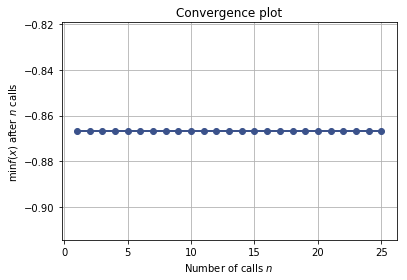

In [23]:
run_optimization()

In [24]:
completed

[('RBFSVC', 'AUGMENT', '4-way'),
 ('RBFSVC', 'AUGMENT', 'binary_pe-v-md'),
 ('RBFSVC', 'AUGMENT', 'binary_pem-v-d'),
 ('RBFSVC', 'BASE', '4-way'),
 ('RBFSVC', 'BASE', 'binary_pe-v-md'),
 ('RBFSVC', 'BASE', 'binary_pem-v-d'),
 ('PolySVC', 'AUGMENT', '4-way'),
 ('PolySVC', 'AUGMENT', 'binary_pe-v-md'),
 ('PolySVC', 'AUGMENT', 'binary_pem-v-d'),
 ('PolySVC', 'BASE', '4-way'),
 ('PolySVC', 'BASE', 'binary_pe-v-md'),
 ('PolySVC', 'BASE', 'binary_pem-v-d')]